In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed
from scipy.integrate import odeint
import math
import random
import itertools
import seaborn as sns
from itertools import product
from collections import Counter
from numba import njit
import copy

/home/anagha/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
num_of_nodes = 3
possible_initial_conditions = []
l = list(itertools.product([0, 1], repeat=num_of_nodes))
for i in range(len(l)):
    possible_initial_conditions.append(list(l[i]))  
    
possible_initial_conditions = np.array(possible_initial_conditions)                                                           



In [3]:
group_map = {
    'A': {'101', '111'},
    'B': {'100', '110'},
    'C': {'010', '011'},
    'D': {'000', '001'}
}

def get_group(state):
    state_str = ''.join(str(bit) for bit in state)
    for group_name, states in group_map.items():
        if state_str in states:
            return group_name
    return None  


In [4]:
def update_states(states, adjacency_matrix):
    states = np.array(states)
    new_states = []

    for i in range(len(states)):
        input_sum = np.dot(adjacency_matrix[i], states)

        if input_sum < 0:
            new_states.append(0)
        elif input_sum > 0:
            new_states.append(1)
            
        else:
            new_states.append(states[i])  

    return new_states


#-------------------------------------------------------------------------------------------------------------

def run_simulation(initial_states, adjacency_matrix, max_iterations=20):
    states = initial_states[:]
    history = [states]

    for interation in range(max_iterations):
        new_states = update_states(states, adjacency_matrix)
        history.append(new_states)
        states = new_states

    return history
#-----------------------------------------------------------------------------------------------------

def normalize_cycle(cycle):
    """Return the lex smallest rotation of a cycle as a tuple of tuples."""
    cycle = [tuple(state) for state in cycle]
    n = len(cycle)
    rotations = [tuple(cycle[i:] + cycle[:i]) for i in range(n)]
    return min(rotations)

#-----------------------------------------------------------

def all_attractors(adjacency_matrix):
    fixed_point_basins = dict()
    cycle_basins = dict()

    for i in range(len(possible_initial_conditions)):
        initial_state = tuple(possible_initial_conditions[i])
        history = run_simulation(list(initial_state), adjacency_matrix)

        for cycle_len in range(1, len(history) // 2 + 1):
            tail = history[-cycle_len:]
            prev_tail = history[-2 * cycle_len:-cycle_len]

            if tail == prev_tail:
                if cycle_len == 1:
                    state = tuple(tail[0])

                    
                    if not (state == (0, 0, 0) and initial_state == (0, 0, 0)):
                        fixed_point_basins.setdefault(state, []).append(initial_state)
                else:
                    normalized = normalize_cycle(tail)
                    cycle_basins.setdefault(normalized, []).append(initial_state)
                break

    result = []

    for fp, basin in fixed_point_basins.items():
        result.append({
            "type": "fixed_point",
            "state": list(fp),
            "group": get_group(fp),
            "basin_size": len(basin),
            "initial_states": [list(s) for s in basin]
        })

    for cyc, basin in cycle_basins.items():
        result.append({
            "type": "cycle",
            "length": len(cyc),
            "states": [list(state) for state in cyc],
            "groups": [get_group(s) for s in cyc],
            "basin_size": len(basin),
            "initial_states": [list(s) for s in basin]
        })

    return result


    


In [5]:
results = []
all_combinations = list(itertools.product([-1, 0, 1], repeat=9))

for combination in all_combinations:
    adjacency_matrix_used = np.array(combination).reshape(3, 3)
    attractors = all_attractors(adjacency_matrix_used)

    results.append({
        "adjacency_matrix": adjacency_matrix_used.tolist(),
        "attractors": attractors
    })


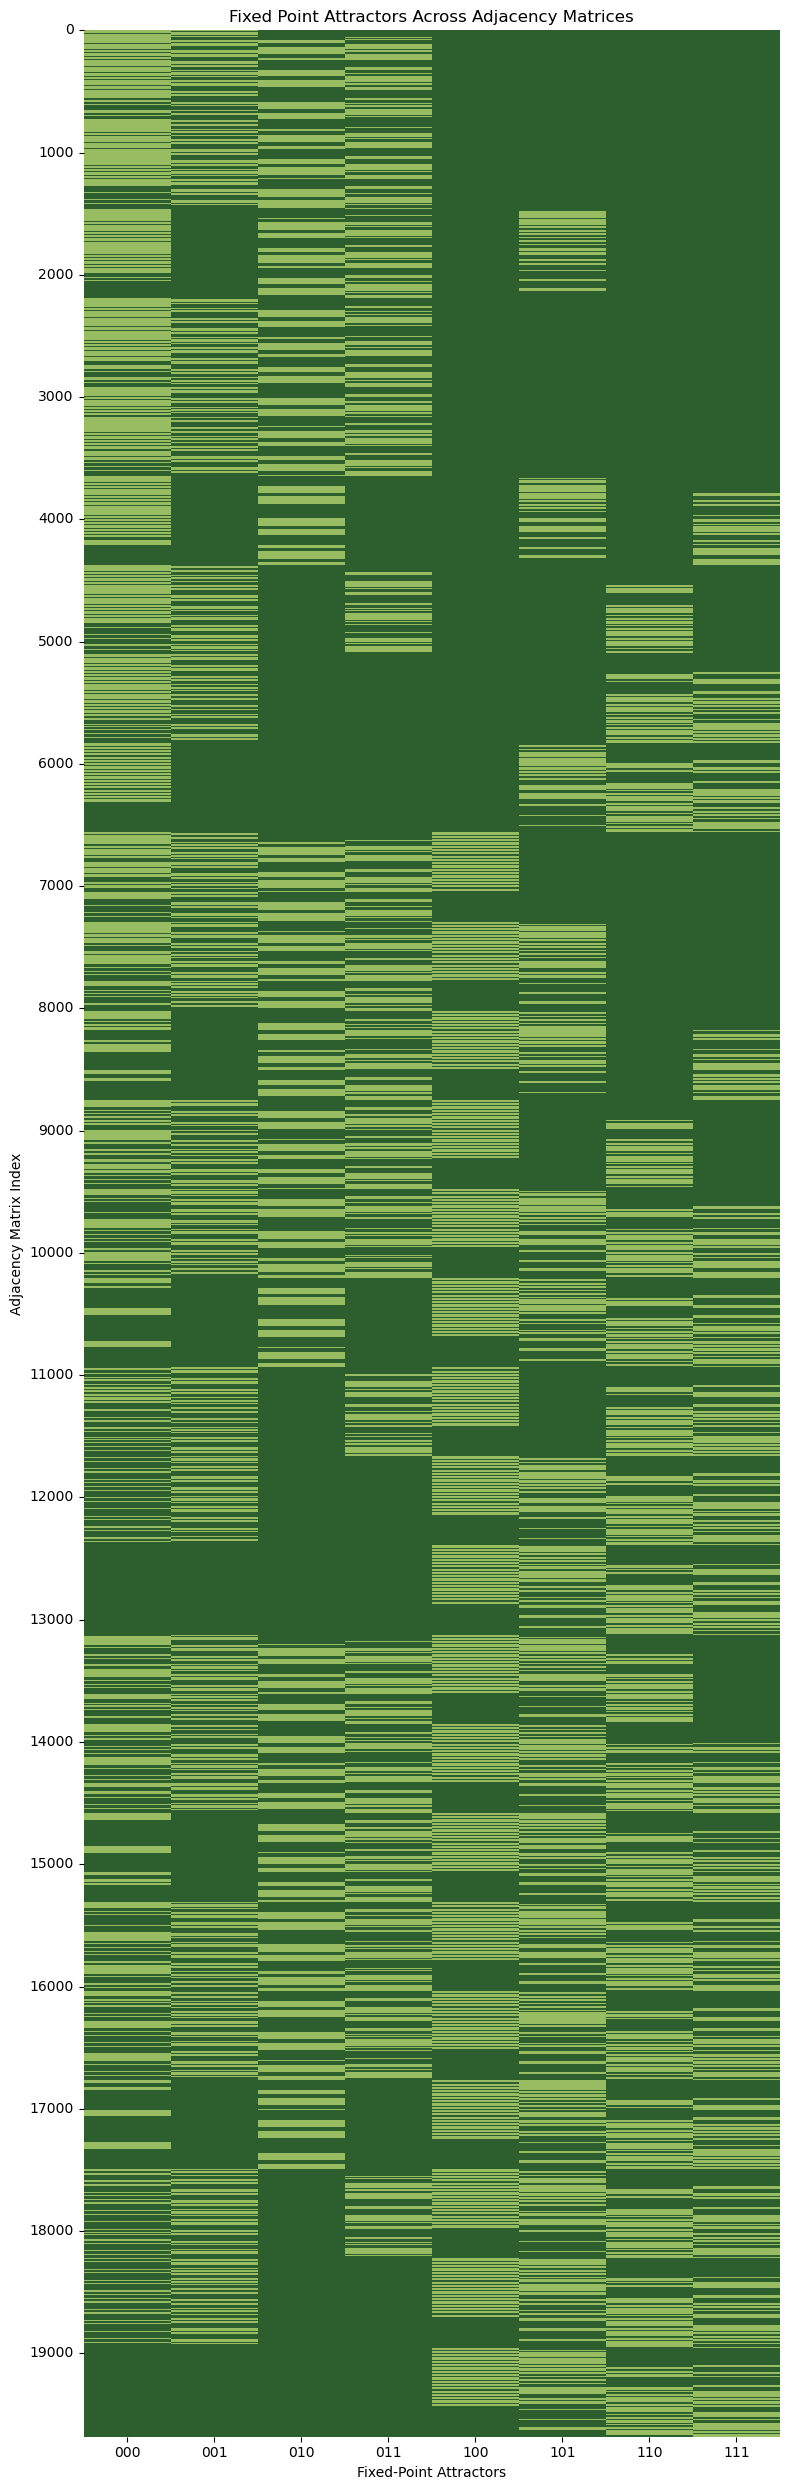

In [6]:

attractor_labels = ['000', '001', '010', '011', '100', '101', '110', '111']
label_to_index = {label: i for i, label in enumerate(attractor_labels)}


cmap = ListedColormap(['#2C5F2D', '#97BC62'])  


heatmap_data = np.zeros((len(results), 8))


for matrix_idx, entry in enumerate(results):
    attractor_list = entry["attractors"]
    for attractor in attractor_list:
        if attractor["type"] == "fixed_point":
            binary_str = ''.join(str(x) for x in attractor["state"])
            if binary_str in label_to_index:
                col_idx = label_to_index[binary_str]
                heatmap_data[matrix_idx][col_idx] = 1

# Set y-tick positions and labels
tick_interval = 1000
yticks = np.arange(0, heatmap_data.shape[0], tick_interval)
ytick_labels = [str(i) for i in yticks]

# Plot the heatmap
plt.figure(figsize=(8, 25)) 
sns.heatmap(
    heatmap_data,
    cmap=cmap,
    cbar=False,
    xticklabels=attractor_labels,
    yticklabels=ytick_labels
)
plt.yticks(ticks=yticks + 0.5, labels=ytick_labels, rotation=0)  
plt.xlabel("Fixed-Point Attractors")
plt.ylabel("Adjacency Matrix Index")
plt.title("Fixed Point Attractors Across Adjacency Matrices")
plt.tight_layout()
plt.show()


{'adjacency_matrix': [[0, -1, 1], [1, 0, -1], [-1, 1, 0]], 'attractors': [{'type': 'fixed_point', 'state': [1, 1, 1], 'group': 'A', 'basin_size': 1, 'initial_states': [[1, 1, 1]]}, {'type': 'cycle', 'length': 6, 'states': [[0, 0, 1], [1, 0, 1], [1, 0, 0], [1, 1, 0], [0, 1, 0], [0, 1, 1]], 'groups': ['D', 'A', 'B', 'B', 'C', 'C'], 'basin_size': 6, 'initial_states': [[0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0]]}]}


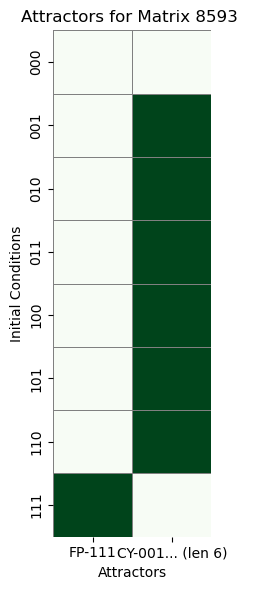

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_basin_heatmap_single(result, title="Initial Conditions → Attractors"):
    initial_labels = ['000', '001', '010', '011', '100', '101', '110', '111']
    label_to_index = {tuple(map(int, list(label))): i for i, label in enumerate(initial_labels)}

    attractor_labels = []
    attractor_map = {}  

    for idx, attractor in enumerate(result):
        if attractor["type"] == "fixed_point":
            label = 'FP-' + ''.join(map(str, attractor["state"]))
        else:
            label = f"CY-{''.join(map(str, attractor['states'][0]))}... (len {attractor['length']})"
        attractor_labels.append(label)
        attractor_map[label] = idx

    heatmap_data = [[0] * len(result) for _ in range(8)]

    for i, attractor in enumerate(result):
        for init_state in attractor["initial_states"]:
            row = label_to_index[tuple(init_state)]
            heatmap_data[row][i] = 1

    plt.figure(figsize=(len(result) * 1.2, 6))
    sns.heatmap(
        heatmap_data,
        xticklabels=attractor_labels,
        yticklabels=initial_labels,
        cmap="Greens",
        linewidths=0.5,
        linecolor='gray',
        cbar=False
    )
    plt.xlabel("Attractors")
    plt.ylabel("Initial Conditions")
    plt.title(title)
    plt.tight_layout()
    plt.show()

index_of_interesting_matrix = 8593
print(results[index_of_interesting_matrix])
this_combiantion = all_combinations[index_of_interesting_matrix]
base_matrix = np.array(this_combiantion).reshape(3, 3)    
result = all_attractors(base_matrix)
plot_basin_heatmap_single(result, title="Attractors for Matrix 8593 ")


000: 0
001: 19230
010: 19230
011: 19422
100: 19230
101: 19422
110: 19422
111: 19410


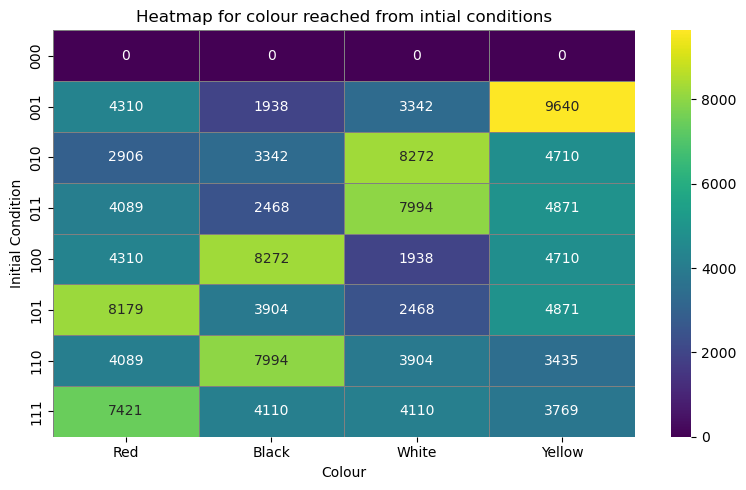

In [8]:
#  How many of the matrices map to a certain basin is the question. 

def group_basin_summary_fixed_points_only(results):
    group_matrix = np.zeros((8, 4))  
    group_index = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    init_labels = ['000', '001', '010', '011', '100', '101', '110', '111']
    init_index = {tuple(map(int, list(s))): i for i, s in enumerate(init_labels)}

    for matrix_result in results:
     
        init_to_group = dict()

        for attractor in matrix_result["attractors"]:
            if attractor["type"] != "fixed_point":
                continue  

            group = attractor["group"]
            for init_state in attractor["initial_states"]:
                init_state = tuple(init_state)

                
                if init_state not in init_to_group:
                    init_to_group[init_state] = group

        
        for init_state, group in init_to_group.items():
            row = init_index[init_state]
            col = group_index[group]
            group_matrix[row][col] += 1

    return group_matrix, init_labels



def plot_group_basin_heatmap(group_matrix, init_labels):
    plt.figure(figsize=(8, 5))
    ax = sns.heatmap(
        group_matrix,
        annot=True,            
        fmt=".0f",             
        cmap="viridis",         
        xticklabels=['Red', 'Black', 'White', 'Yellow'],
        yticklabels=init_labels,
        linewidths=0.5,
        linecolor='gray',
        cbar=True               
    )
    ax.set_xlabel("Colour")
    ax.set_ylabel("Initial Condition")
    ax.set_title("Heatmap for colour reached from intial conditions")
    plt.tight_layout()
    plt.show()


group_matrix, init_labels = group_basin_summary_fixed_points_only(results)


row_totals = np.sum(group_matrix, axis=1)
for i, total in enumerate(row_totals):
    print(f"{init_labels[i]}: {int(total)}")


plot_group_basin_heatmap(group_matrix, init_labels)



In [33]:
# Neighbour matrcies

def generate_one_edge_mutants(matrix):
    mutants = []
    matrix = np.array(matrix)

    allowed_transitions = {
        (0, 1),
        (0, -1),
        (1, 0),
        (-1, 0)
    }

    for i in range(3):
        for j in range(3):
            current_val = matrix[i, j]
            for new_val in [-1, 0, 1]:
                if (current_val, new_val) in allowed_transitions:
                    mutated = matrix.copy()
                    mutated[i, j] = new_val
                    mutants.append(mutated.tolist())
    return mutants

# -------------------------------------------
# all_attarctors for neighbours

def analyze_neighbors(base_matrix):
    neighbors = generate_one_edge_mutants(base_matrix)
    results = []

    for neighbor in neighbors:
        attractors = all_attractors(neighbor)
        results.append({
            "adjacency_matrix": neighbor,
            "attractors": attractors
        })

    return results


In [25]:
# For a given matrix, I can get results for it and all of the "neighbour" matrices.

index_of_interesting_matrix = 17133
print(results[index_of_interesting_matrix])
this_combiantion = all_combinations[index_of_interesting_matrix]
base_matrix = np.array(this_combiantion).reshape(3, 3)
print(base_matrix)
neighbor_data = analyze_neighbors(base_matrix)
print("-" * 40)
for entry in neighbor_data:
    print("Mutant Matrix:")
    for row in entry["adjacency_matrix"]:
        print(row)
    print("Attractors:")
    for a in entry["attractors"]:
        print(a)
   
    flattened_mutant = tuple(np.array(entry["adjacency_matrix"]).flatten())
    mutant_index = all_combinations.index(flattened_mutant)
    print(f"Mutant Index in results: {mutant_index}")
    print("-" * 30)

{'adjacency_matrix': [[1, 0, 1], [0, 0, 0], [0, 1, -1]], 'attractors': [{'type': 'fixed_point', 'state': [1, 0, 0], 'group': 'B', 'basin_size': 3, 'initial_states': [[0, 0, 1], [1, 0, 0], [1, 0, 1]]}, {'type': 'fixed_point', 'state': [1, 1, 1], 'group': 'A', 'basin_size': 4, 'initial_states': [[0, 1, 0], [0, 1, 1], [1, 1, 0], [1, 1, 1]]}]}
[[ 1  0  1]
 [ 0  0  0]
 [ 0  1 -1]]
----------------------------------------
Mutant Matrix:
[0, 0, 1]
[0, 0, 0]
[0, 1, -1]
Attractors:
{'type': 'fixed_point', 'state': [1, 0, 0], 'group': 'B', 'basin_size': 3, 'initial_states': [[0, 0, 1], [1, 0, 0], [1, 0, 1]]}
{'type': 'fixed_point', 'state': [1, 1, 1], 'group': 'A', 'basin_size': 4, 'initial_states': [[0, 1, 0], [0, 1, 1], [1, 1, 0], [1, 1, 1]]}
Mutant Index in results: 10572
------------------------------
Mutant Matrix:
[1, 0, 0]
[0, 0, 0]
[0, 1, -1]
Attractors:
{'type': 'fixed_point', 'state': [0, 0, 0], 'group': 'D', 'basin_size': 1, 'initial_states': [[0, 0, 1]]}
{'type': 'fixed_point', 'stat

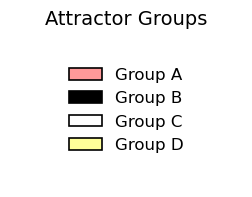

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define group-color mapping
group_colors = {
    'A': '#FF9999',
    'B': '#000000',
    'C': '#FFFFFF',
    'D': '#FFFF99'
}

# Create legend handles with edgecolor for box
legend_patches = [
    mpatches.Patch(
        facecolor=color,
        edgecolor='black',
        linewidth=1.2,
        label=f'Group {group}'
    )
    for group, color in group_colors.items()
]

# Plot just the legend
fig, ax = plt.subplots(figsize=(3, 2)) 

ax.axis('off')  # Turn off the axis
ax.legend(
    handles=legend_patches,
    loc='center',
    frameon=False,  # No box around the whole legend
    fontsize=12
)

plt.title('Attractor Groups', fontsize=14)
plt.show()


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_basin_heatmap_single(result, title="Initial Conditions → Attractors"):
    initial_labels = ['000', '001', '010', '011', '100', '101', '110', '111']
    label_to_index = {tuple(map(int, list(label))): i for i, label in enumerate(initial_labels)}

   
    attractor_labels = []
    for a in result:
        if a["type"] == "fixed_point":
            label = 'FP-' + ''.join(map(str, a["state"])) + f' ({a["group"]})'
        else: 
           
            first_state = ''.join(map(str, a["states"][0]))
            unique_groups = set(a["groups"])
            group_str = ','.join(sorted(unique_groups))
            label = f'CY-{first_state}... (len {a["length"]}, {group_str})' + + f' ({a["group"]})'
        attractor_labels.append(label)

   
    heatmap_data = np.zeros((8, len(result)), dtype=int)

   
    for col, attractor in enumerate(result):
        init_states = attractor.get("initial_states", [])
        if init_states:
            indices = [label_to_index[tuple(state)] for state in init_states]
            heatmap_data[indices, col] = 1

    
    plt.figure(figsize=(len(result) * 1.2, 6))
    sns.heatmap(
        heatmap_data,
        xticklabels=attractor_labels,
        yticklabels=initial_labels,
        cmap="Greens",
        linewidths=0.5,
        linecolor='gray',
        cbar=False
    )
    plt.xlabel("Attractors")
    plt.ylabel("Initial Conditions")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    
    


In [45]:
results[16600]

{'adjacency_matrix': [[1, 0, 0], [1, -1, 1], [1, 0, 0]],
 'attractors': [{'type': 'fixed_point',
   'state': [0, 1, 1],
   'group': 'C',
   'basin_size': 2,
   'initial_states': [[0, 0, 1], [0, 1, 1]]},
  {'type': 'fixed_point',
   'state': [0, 0, 0],
   'group': 'D',
   'basin_size': 1,
   'initial_states': [[0, 1, 0]]},
  {'type': 'fixed_point',
   'state': [1, 1, 1],
   'group': 'A',
   'basin_size': 4,
   'initial_states': [[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]}]}

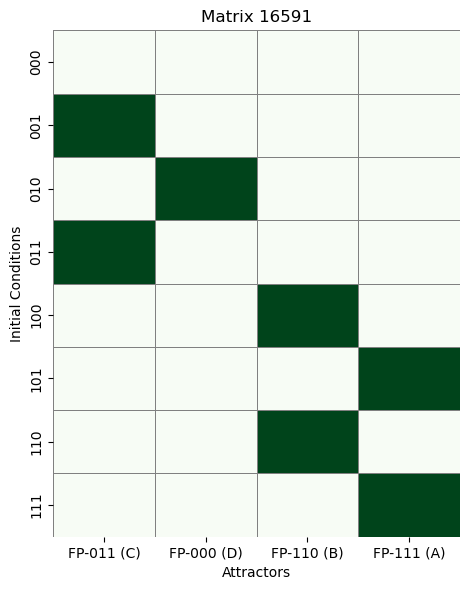

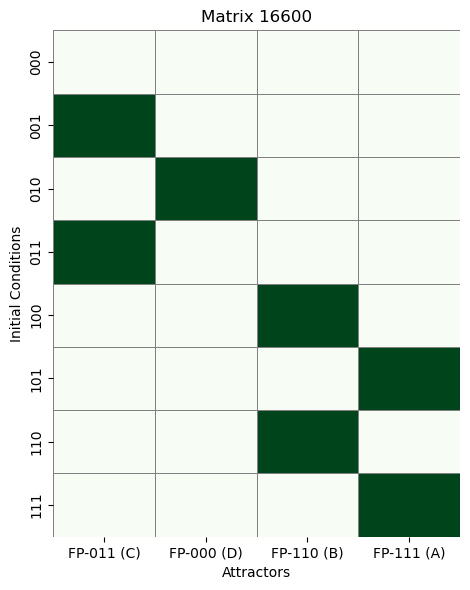

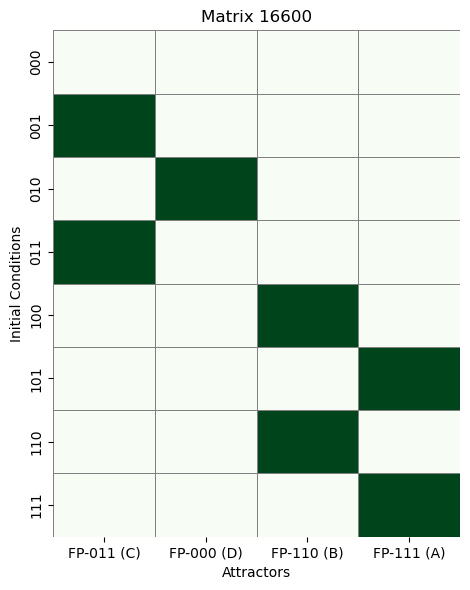

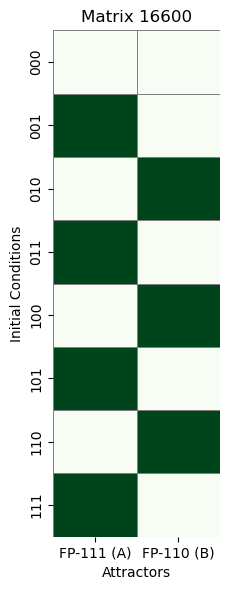

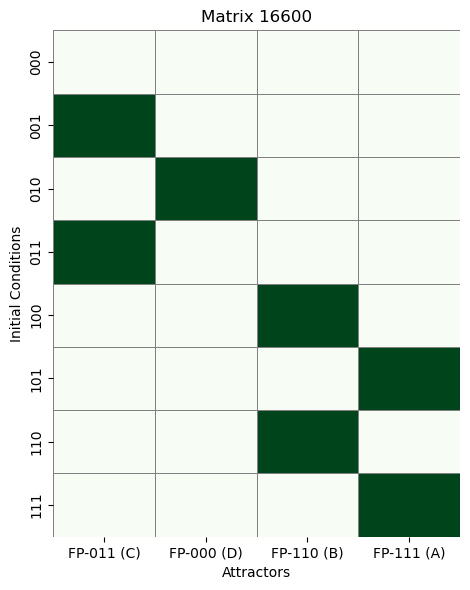

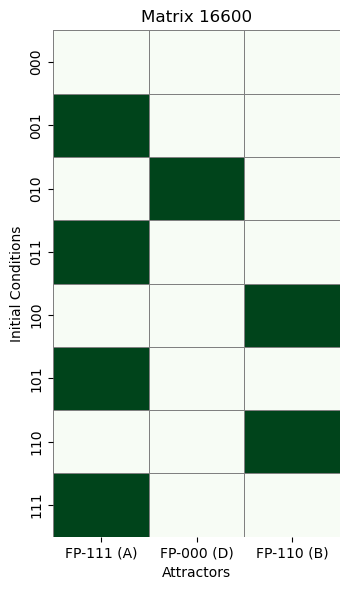

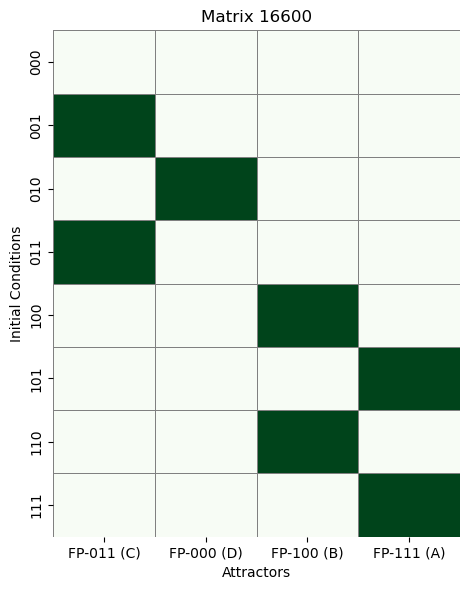

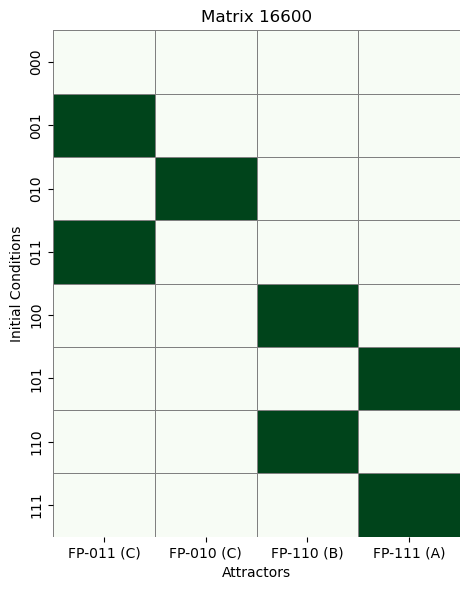

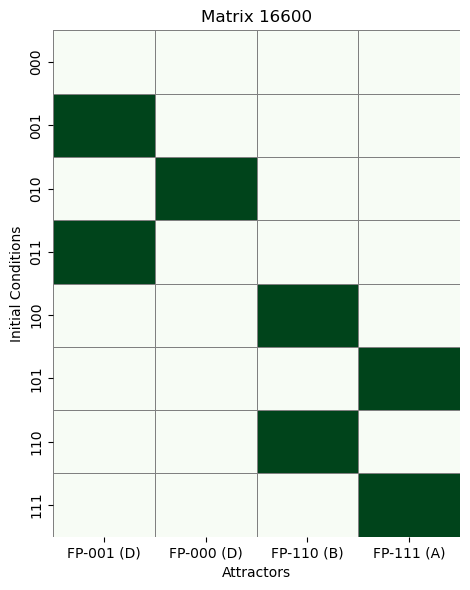

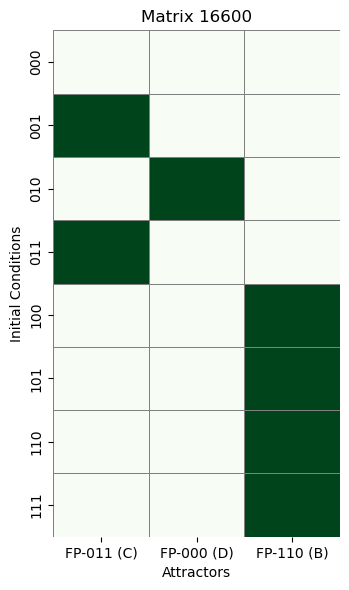

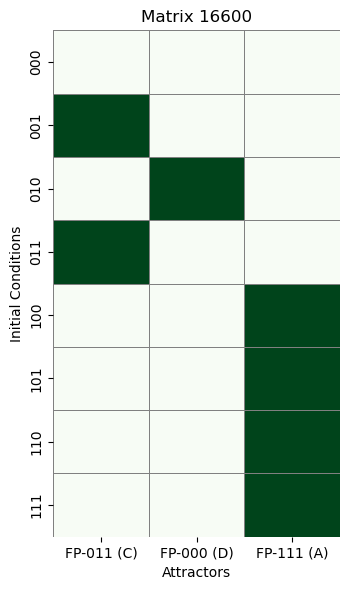

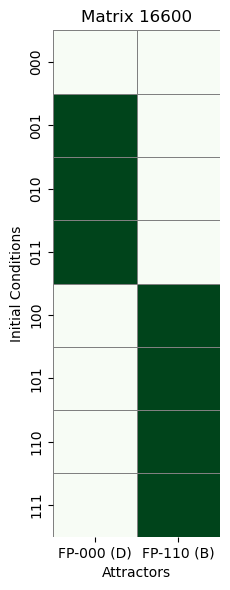

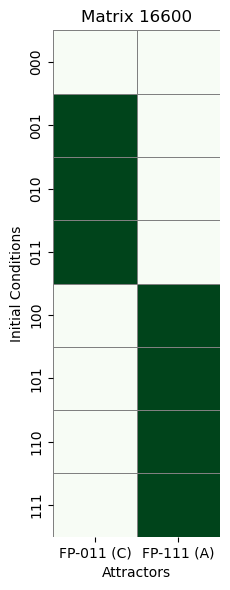

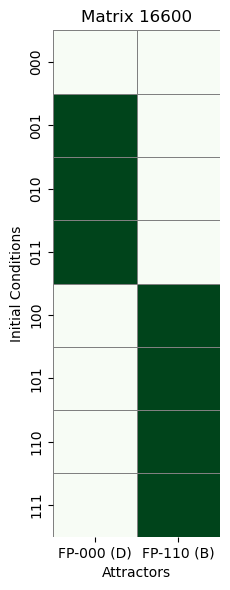

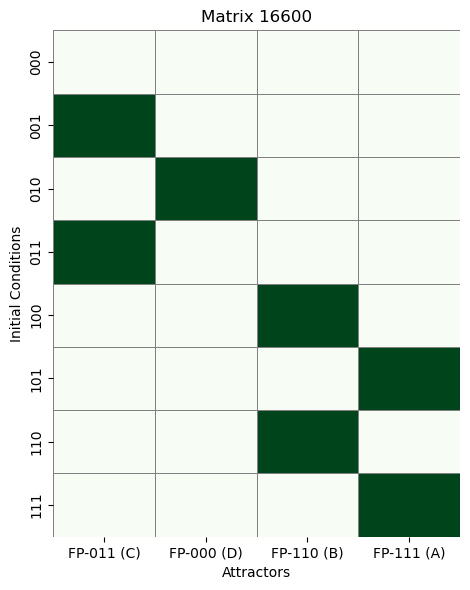

In [38]:
# 8161,9542 is a nice matrix. It has AB neigbour and CD only neighbour also. Juts can't take 000 as inital point.
#18778 wnt low and 16600 high
index_of_interesting_matrix = 16591
this_combination = all_combinations[index_of_interesting_matrix]
base_matrix = np.array(this_combination).reshape(3, 3)


base_result = all_attractors(base_matrix)
plot_basin_heatmap_single(base_result, title="Matrix 16591")


for i, neighbor in enumerate(analyze_neighbors(base_matrix)):
    attractors = neighbor.get("attractors", [])
    plot_basin_heatmap_single(attractors, title="Matrix 16600")


In [27]:
matrices_with_all_fixed_point_groups = []

for idx, entry in enumerate(results):
    fixed_point_groups = set()

    for attractor in entry["attractors"]:
        if attractor["type"] == "fixed_point":
            fixed_point_groups.add(attractor["group"])
        elif attractor["type"] == "cycle":
            unique_groups = set(attractor["groups"])
            if len(unique_groups) == 1:
                fixed_point_groups.update(unique_groups)
            else :
                fixed_point_groups.add("Z")
    if fixed_point_groups == {"A", "C", "D", "B"}:
        matrices_with_all_fixed_point_groups.append({
            "index": idx,
            "entry": entry
        })


In [16]:
len(matrices_with_all_fixed_point_groups)



958

In [28]:
qualified_matrices = []

for item in matrices_with_all_fixed_point_groups:
    idx = item["index"]
    base_entry = item["entry"]
    base_matrix = base_entry["adjacency_matrix"]

    neighbors = generate_one_edge_mutants(base_matrix)

    for neighbor in neighbors:
        attractors = all_attractors(neighbor)

        if not attractors:
            continue

        groups_in_mutant = set()
        for attractor in attractors:
            if attractor["type"] == "fixed_point":
                groups_in_mutant.add(attractor["group"])
            elif attractor["type"] == "cycle":
                empty_set = set(attractor["groups"])
                if len(empty_set) == 1:
                    groups_in_mutant.update(attractor["groups"])
                else:
                    groups_in_mutant.update({"Z"})
                

        if groups_in_mutant == {"D","A","C"}:
       
            for mutant_idx, result in enumerate(results):
                if result["adjacency_matrix"] == neighbor:
                    qualified_matrices.append({
                        "matrix_index": idx,                   
                        "base_matrix": base_matrix,
                        "neighbor_with_only_A": neighbor,
                        "mutant_index": mutant_idx              
                    })
                    break
            break  


In [29]:
qualified_matrices

[{'matrix_index': 9657,
  'base_matrix': [[0, 0, 0], [-1, 1, -1], [1, -1, -1]],
  'neighbor_with_only_A': [[0, 0, 0], [-1, 0, -1], [1, -1, -1]],
  'mutant_index': 9576},
 {'matrix_index': 9658,
  'base_matrix': [[0, 0, 0], [-1, 1, -1], [1, -1, 0]],
  'neighbor_with_only_A': [[0, 0, 0], [-1, 0, -1], [1, -1, 0]],
  'mutant_index': 9577},
 {'matrix_index': 9659,
  'base_matrix': [[0, 0, 0], [-1, 1, -1], [1, -1, 1]],
  'neighbor_with_only_A': [[0, 0, 0], [-1, 0, -1], [1, -1, 1]],
  'mutant_index': 9578},
 {'matrix_index': 9684,
  'base_matrix': [[0, 0, 0], [-1, 1, 0], [1, -1, -1]],
  'neighbor_with_only_A': [[0, 0, 0], [-1, 0, 0], [1, -1, -1]],
  'mutant_index': 9603},
 {'matrix_index': 9685,
  'base_matrix': [[0, 0, 0], [-1, 1, 0], [1, -1, 0]],
  'neighbor_with_only_A': [[0, 0, 0], [-1, 0, 0], [1, -1, 0]],
  'mutant_index': 9604},
 {'matrix_index': 9686,
  'base_matrix': [[0, 0, 0], [-1, 1, 0], [1, -1, 1]],
  'neighbor_with_only_A': [[0, 0, 0], [-1, 0, 0], [1, -1, 1]],
  'mutant_index': 9

In [107]:
all_attractors

False


In [19]:
index_of_interesting_matrix = 5162
this_combination = all_combinations[index_of_interesting_matrix]
base_matrix = np.array(this_combination).reshape(3, 3)
attractors = all_attractors(base_matrix) 
for attractor in attractors:
    print(attractor["type"])
    if attractor["type"] ==  "cycle":
        print(attractor["groups"])
        print(type(attractor["groups"]))

fixed_point
cycle
['D', 'C', 'A', 'A']
<class 'list'>


In [30]:
qualified_matrices_wnt_low = []

for item in matrices_with_all_fixed_point_groups:
    idx = item["index"]
    base_entry = item["entry"]
    base_matrix = base_entry["adjacency_matrix"]

    neighbors = generate_one_edge_mutants(base_matrix)

    for neighbor in neighbors:
        attractors = all_attractors(neighbor)

        if not attractors:
            continue

        groups_in_mutant = set()
        for attractor in attractors:
            if attractor["type"] == "fixed_point":
                groups_in_mutant.add(attractor["group"])
            elif attractor["type"] == "cycle":
                empty_set = set(attractor["groups"])
                if len(empty_set) == 1:
                    groups_in_mutant.update(attractor["groups"])
                else:
                    groups_in_mutant.update({"Z"})
                

        if groups_in_mutant == {"A","B"}:
       
            for mutant_idx, result in enumerate(results):
                if result["adjacency_matrix"] == neighbor:
                    qualified_matrices_wnt_low.append({
                        "matrix_index": idx,                   
                        "base_matrix": base_matrix,
                        "neighbor_with_only_A": neighbor,
                        "mutant_index": mutant_idx              
                    })
                    break
            break  


In [31]:
qualified_matrices_wnt_low

[{'matrix_index': 8081,
  'base_matrix': [[0, -1, 1], [-1, -1, 1], [-1, 1, 1]],
  'neighbor_with_only_A': [[0, 0, 1], [-1, -1, 1], [-1, 1, 1]],
  'mutant_index': 10268},
 {'matrix_index': 8135,
  'base_matrix': [[0, -1, 1], [-1, 0, 0], [-1, 1, 1]],
  'neighbor_with_only_A': [[0, 0, 1], [-1, 0, 0], [-1, 1, 1]],
  'mutant_index': 10322},
 {'matrix_index': 8161,
  'base_matrix': [[0, -1, 1], [-1, 0, 1], [-1, 1, 0]],
  'neighbor_with_only_A': [[0, 0, 1], [-1, 0, 1], [-1, 1, 0]],
  'mutant_index': 10348},
 {'matrix_index': 8162,
  'base_matrix': [[0, -1, 1], [-1, 0, 1], [-1, 1, 1]],
  'neighbor_with_only_A': [[0, 0, 1], [-1, 0, 1], [-1, 1, 1]],
  'mutant_index': 10349},
 {'matrix_index': 8323,
  'base_matrix': [[0, -1, 1], [0, -1, 1], [-1, 1, 0]],
  'neighbor_with_only_A': [[0, 0, 1], [0, -1, 1], [-1, 1, 0]],
  'mutant_index': 10510},
 {'matrix_index': 8324,
  'base_matrix': [[0, -1, 1], [0, -1, 1], [-1, 1, 1]],
  'neighbor_with_only_A': [[0, 0, 1], [0, -1, 1], [-1, 1, 1]],
  'mutant_index'

In [32]:
ids1 = {d["matrix_index"] for d in qualified_matrices}
ids2 = {d["matrix_index"] for d in qualified_matrices_wnt_low}
common_ids = ids1 & ids2
print(common_ids)

set()


In [23]:
list_wnt_high = []
list_wnt_low = []
for i in common_ids:
    for d in qualified_matrices:
        if d["matrix_index"] == i:
            list_wnt_high.append(d["mutant_index"])
    for d in qualified_matrices_wnt_low:
        if d["matrix_index"] == i:
            list_wnt_low.append(d["mutant_index"])            

In [24]:
def count_initial_conditions_per_group(indices, results):
    summary = []

    for i in indices:
        entry = results[i]
        attractors = entry["attractors"]

        group_counts = {'A': 0, 'B': 0, 'C': 0, 'D': 0}

        for attractor in attractors:
            if attractor["type"] == "fixed_point":
                g = attractor["group"]
                if g in group_counts:
                    group_counts[g] += len(attractor["initial_states"])

            elif attractor["type"] == "cycle":
                g = attractor["groups"][0]  # safe because it's a clean cycle
                if g in group_counts:
                    group_counts[g] += len(attractor["initial_states"])

        summary.append({
            "index": i,
            "adjacency_matrix": entry["adjacency_matrix"],
            **group_counts
        })

    return summary


group_summary = count_initial_conditions_per_group(list_wnt_high, results)
group_summary_1 = count_initial_conditions_per_group(list_wnt_low, results)
for a, b, c in zip(group_summary, group_summary_1, common_ids):
    print(f"Matrix {a['index']}: A={a['A']} B={a['B']} C={a['C']} D={a['D']}")
    print(f"Matrix {b['index']}: A={b['A']} B={b['B']} C={b['C']} D={b['D']}")
    print(c)
    print("-" * 30)

Matrix 17369: A=5 B=2 C=0 D=0
Matrix 16649: A=4 B=0 C=2 D=1
16640
------------------------------
Matrix 10330: A=6 B=1 C=0 D=0
Matrix 9610: A=4 B=0 C=2 D=1
9601
------------------------------
Matrix 10331: A=6 B=1 C=0 D=0
Matrix 9611: A=4 B=0 C=2 D=1
9602
------------------------------
Matrix 17133: A=4 B=3 C=0 D=0
Matrix 16647: A=4 B=0 C=2 D=1
16404
------------------------------
Matrix 17134: A=6 B=1 C=0 D=0
Matrix 16648: A=4 B=0 C=2 D=1
16405
------------------------------
Matrix 17135: A=6 B=1 C=0 D=0
Matrix 16649: A=4 B=0 C=2 D=1
16406
------------------------------
Matrix 10861: A=3 B=4 C=0 D=0
Matrix 10141: A=4 B=0 C=2 D=1
10132
------------------------------
Matrix 10862: A=5 B=2 C=0 D=0
Matrix 7946: A=1 B=0 C=5 D=1
10133
------------------------------
Matrix 16891: A=6 B=1 C=0 D=0
Matrix 16171: A=4 B=0 C=2 D=1
16162
------------------------------
Matrix 16892: A=6 B=1 C=0 D=0
Matrix 16172: A=4 B=0 C=2 D=1
16163
------------------------------
Matrix 10626: A=4 B=3 C=0 D=0
Matri

In [ ]:
# I am using 16591 matrix and 2 of its mutants: 18778 wnt low and 16600 for wnt high............

In [247]:
results[0]

{'adjacency_matrix': [[-1, -1, -1], [-1, -1, -1], [-1, -1, -1]],
 'attractors': [{'type': 'fixed_point',
   'state': [0, 0, 0],
   'group': 'D',
   'basin_size': 7,
   'initial_states': [[0, 0, 1],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1]]}]}

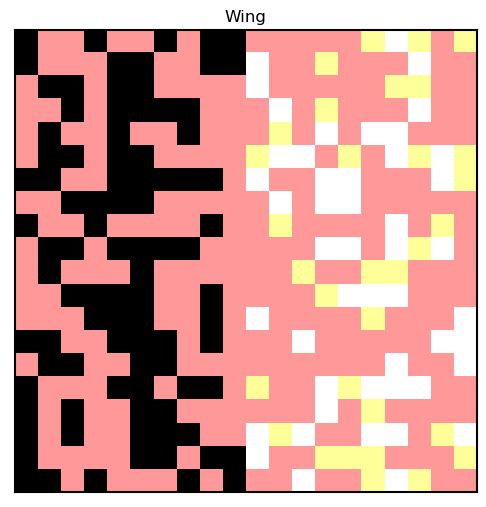

In [59]:

grid_rows, grid_cols = 20, 20  
num_nodes = 3
all_combinations = list(itertools.product([-1, 0, 1], repeat=9))


index_of_interesting_matrix = 18778
this_combination = all_combinations[index_of_interesting_matrix]
adj_matrix1 = np.array(this_combination).reshape(3, 3)

index_of_interesting_matrix = 16600
this_combination = all_combinations[index_of_interesting_matrix]
adj_matrix2 = np.array(this_combination).reshape(3, 3)


# Group mapping
group_map = {
    'A': {'101', '111'},
    'B': {'100', '110'},
    'C': {'010', '011'},
    'D': {'000', '001'}
}

group_colors = {
    'A': '#FF9999',  # red
    'B': '#000000',  # balck
    'C': '#FFFFFF',  # white
    'D': '#FFFF99'   # yellow
}


def get_group(state):
    state_str = ''.join(str(bit) for bit in state)
    for group_name, states in group_map.items():
        if state_str in states:
            return group_name
    raise ValueError(f"State {state} does not belong to any defined group.")

def update_states(states, adjacency_matrix):
    new_states = []
    for i in range(len(states)):
        input_sum = np.dot(adjacency_matrix[i], states)
        if input_sum < 0:
            new_states.append(0)
        elif input_sum > 0:
            new_states.append(1)
        else:
            new_states.append(states[i])
    return new_states

def run_simulation(initial_state, adjacency_matrix, max_iter=20):
    states = list(initial_state)
    for _ in range(max_iter):
        new_states = update_states(states, adjacency_matrix)
        if new_states == states:
            break
        states = new_states
    return states

def generate_random_state_excluding_000():
    while True:
        state = list(np.random.choice([0, 1], size=num_nodes))
        if state != [0, 0, 0]:
            return state


final_groups = []

for row in range(grid_rows):
    for col in range(grid_cols):
        matrix = adj_matrix1 if col < grid_cols // 2 else adj_matrix2
        init_state = generate_random_state_excluding_000()
        final_state = run_simulation(init_state, matrix)
        group = get_group(final_state)
        final_groups.append(group)

group_to_int = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
int_grid = np.array([group_to_int[g] for g in final_groups]).reshape((grid_rows, grid_cols))

# Create colormap
color_list = [group_colors[g] for g in ['A', 'B', 'C', 'D']]
cmap = mcolors.ListedColormap(color_list)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(int_grid, cmap=cmap)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Wing")
plt.show()


In [275]:

grid_size = 20
num_nodes = 3
timesteps = 1200

all_combinations = list(itertools.product([-1, 0, 1], repeat=9))



group_map = {
    'A': {'101', '111'},
    'B': {'100', '110'},
    'C': {'010', '011'},
    'D': {'000', '001'}
}

group_colors = {
    'A': '#FF9999',  # light red
    'B': '#000000',  # black
    'C': '#FFFFFF',  # white
    'D': '#FFFF99'   # light yellow
}

def get_group(state):
    state_str = ''.join(str(bit) for bit in state)
    for group_name, states in group_map.items():
        if state_str in states:
            return group_name
    return None

def get_neighbors(i, j, size):
    return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)] if 0 <= ni < size and 0 <= nj < size]

def compute_cell_update(i, j, grid, local_adj_1, local_adj_2, inter_cell_adj):
    if j <= grid_size//3:
        local_adj = local_adj_2
    elif j <= grid_size*2//3:
        local_adj = local_adj_1
    else:
        local_adj = local_adj_2
    own_state = np.array(grid[i][j])
    new_state = []

    for k in range(num_nodes):
        local_input = np.dot(local_adj[k], own_state)

        neighbor_input = 0
        for ni, nj in get_neighbors(i, j, grid_size):
            neighbor_state = np.array(grid[ni][nj])
            neighbor_input += np.dot(inter_cell_adj[k], neighbor_state)

        total_input = local_input + neighbor_input

        if total_input < 0:
            new_state.append(0)
        elif total_input > 0:
            new_state.append(1)
        else:
            new_state.append(own_state[k])

    return new_state


In [264]:


possible_initial_conditions = list(itertools.product([0, 1], repeat=num_nodes))
intial_conditions_for_grid = [[list(random.choice(possible_initial_conditions)) for _ in range(grid_size)] for _ in range(grid_size)]
intial_conditions_for_grid = []
for i in range(grid_size):
    row = []
    for j in range(grid_size):
        if j >= grid_size//2:
            row.append([1, 1, 0])
        else: 
            row.append([0, 0, 0])
            
     
    intial_conditions_for_grid.append(row)
intial_conditions_for_grid = [[list(random.choice(possible_initial_conditions)) for _ in range(grid_size)] for _ in range(grid_size)]



In [197]:
unique_groups = set()
for row in initial_conditions_for_grid:
    for state in row:
        unique_groups.add(get_group(state))

print("Groups present:", unique_groups)

Groups present: {'B', 'A'}


In [276]:
index_of_interesting_matrix = 18778
this_combination = all_combinations[index_of_interesting_matrix]
local_adj_1 = np.array(this_combination).reshape(3, 3)

index_of_interesting_matrix = 16600
this_combination = all_combinations[index_of_interesting_matrix]
local_adj_2 = np.array(this_combination).reshape(3, 3)

index_of_interesting_matrix = 1234
this_combination = all_combinations[index_of_interesting_matrix]
inter_cell_adj = np.array(this_combination).reshape(3, 3)


'''inter_cell_adj = np.array([[ 1, 0, 0],
                           [ 0, 1, 0],
                           [ 0, 0, 1]])

'''

'inter_cell_adj = np.array([[ 1, 0, 0],\n                           [ 0, 1, 0],\n                           [ 0, 0, 1]])\n\n'

In [277]:
grid = copy.deepcopy(intial_conditions_for_grid)
history = []
timesteps = 1000
for t in range(timesteps):
    history.append([[cell.copy() for cell in row] for row in grid])

    new_grid = [[None for _ in range(grid_size)] for _ in range(grid_size)]

    for i in range(grid_size):
        for j in range(grid_size):
            updated_state = compute_cell_update(i, j, grid, local_adj_1, local_adj_2, inter_cell_adj)
            new_grid[i][j] = updated_state

    grid = new_grid



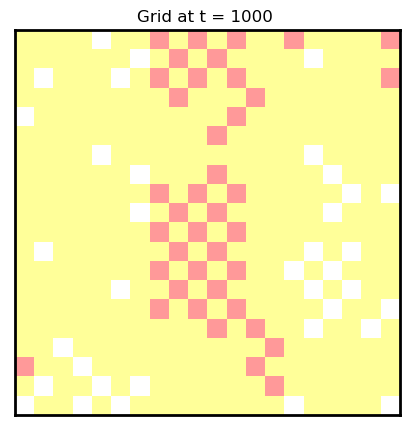

In [278]:

color_grid = []
for i in range(grid_size):
    row = []
    for j in range(grid_size):
        group = get_group(grid[i][j])
        row.append(group_colors.get(group, '#808080'))  
    color_grid.append(row)

color_grid = np.array(color_grid)


unique_colors = list(group_colors.values()) + ['#808080']
color_to_int = {c: i for i, c in enumerate(unique_colors)}
int_grid = np.vectorize(color_to_int.get)(color_grid)

cmap = mcolors.ListedColormap(unique_colors)
bounds = list(range(len(unique_colors) + 1))
norm = mcolors.BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(int_grid, cmap=cmap, norm=norm)



for i in range(grid_size):
    for j in range(grid_size):
        group = get_group(grid[i][j])
        
        #ax.text(j, i, group , ha='center', va='center', fontsize=12)
#ax.legend(handles=legend_patches, frameon=True)  # Adds box around legend

ax.set_title(f"Grid at t = {timesteps} ")
#ax.set_title("Final")
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(2)

#ax.axis('off')
ax.set_xticks([]) 
ax.set_yticks([]) 
plt.show()


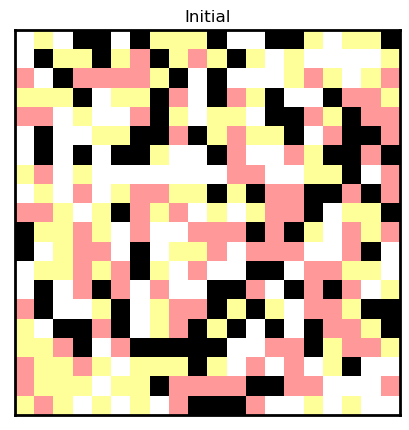

In [271]:

initial_grid = history[0]

color_grid = []
for i in range(grid_size):
    row = []
    for j in range(grid_size):
        group = get_group(initial_grid[i][j])
        row.append(group_colors.get(group, '#808080'))  
    color_grid.append(row)

color_grid = np.array(color_grid)


unique_colors = list(group_colors.values()) + ['#808080']
color_to_int = {c: i for i, c in enumerate(unique_colors)}
int_grid = np.vectorize(color_to_int.get)(color_grid)

cmap = mcolors.ListedColormap(unique_colors)
bounds = list(range(len(unique_colors) + 1))
norm = mcolors.BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(int_grid, cmap=cmap, norm=norm)


for i in range(grid_size):
    for j in range(grid_size):
        group = get_group(initial_grid[i][j])
        #ax.text(j, i, group , ha='center', va='center', fontsize=12)

#ax.set_title("Grid at t = 0 ")
ax.set_title("Initial")
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(2)
#ax.axis('off')
ax.set_xticks([]) 
ax.set_yticks([]) 
plt.show()


In [145]:

grid_size = 5
num_nodes = 3
timesteps = 100

# --- Generate all 3x3 inter-cell matrices (with diagonal entries) ---
def generate_all_3x3_matrices():
    all_combinations = list(product([-1, 0, 1], repeat=9))
    return [np.array(c).reshape(3, 3) for c in all_combinations]

all_inter_matrices = generate_all_3x3_matrices()

# --- All valid 3-bit states ---
possible_initial_conditions = np.array(list(product([0, 1], repeat=num_nodes)))

# --- Integer-based group encoding ---
@njit
def encode_group(state):
    s = state[0]*4 + state[1]*2 + state[2]
    if s == 5 or s == 7: return 0  # A
    if s == 4 or s == 6: return 1  # B
    if s == 2 or s == 3: return 2  # C
    return 3  # D

group_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

# --- Get neighbors ---
@njit
def get_neighbors(i, j, size):
    neighbors = []
    if i > 0: neighbors.append((i-1, j))
    if i < size - 1: neighbors.append((i+1, j))
    if j > 0: neighbors.append((i, j-1))
    if j < size - 1: neighbors.append((i, j+1))
    return neighbors

# --- Numba-accelerated cell update ---
@njit
def compute_cell_update(i, j, grid, local_adj, inter_adj, size):
    own_state = grid[i, j]
    new_state = np.empty(3, dtype=np.int32)

    for k in range(3):
        local_input = 0
        for l in range(3):
            local_input += local_adj[k, l] * own_state[l]

        neighbor_input = 0
        neighbors = get_neighbors(i, j, size)
        for ni, nj in neighbors:
            for l in range(3):
                neighbor_input += inter_adj[k, l] * grid[ni, nj, l]

        total_input = local_input + neighbor_input
        new_state[k] = 0 if total_input < 0 else (1 if total_input > 0 else own_state[k])

    return new_state

# --- Numba-accelerated simulation loop ---
@njit
def run_simulation(grid, local_adj, inter_adj, size, steps):
    for _ in range(steps):
        new_grid = np.empty_like(grid)
        for i in range(size):
            for j in range(size):
                new_grid[i, j] = compute_cell_update(i, j, grid, local_adj, inter_adj, size)
        grid = new_grid
    return grid

# --- Random initial grid ---
def random_initial_grid(size):
    grid = np.empty((size, size, 3), dtype=np.int32)
    for i in range(size):
        for j in range(size):
            grid[i, j] = random.choice(possible_initial_conditions)
    return grid

# --- Compute group stats (no entropy, no homogeneity) ---
def compute_group_summary(group_grid):
    flat = [g for row in group_grid for g in row]
    total = len(flat)
    counts = Counter(flat)
    dominant_group, _ = counts.most_common(1)[0]
    percentages = {group_labels[g]: counts.get(g, 0) / total for g in range(4)}
    return {
        "dominant_group": group_labels[dominant_group],
        "group_percentages": percentages
    }

# --- Example local GRN to use ---
index_of_interesting_matrix = 17133
this_combination = list(product([-1, 0, 1], repeat=9))[index_of_interesting_matrix]
local_adj = np.array(this_combination).reshape(3, 3)

# --- Main loop for testing (only 5 matrices here) ---
all_summaries = []
for i in range(len(all_inter_matrices)):  # Change to len(all_inter_matrices) for full run
    inter_matrix = all_inter_matrices[i]
    init_grid = random_initial_grid(grid_size)
    final_grid = run_simulation(init_grid, local_adj, inter_matrix, grid_size, timesteps)

    group_grid = [[encode_group(final_grid[i, j]) for j in range(grid_size)] for i in range(grid_size)]
    summary = compute_group_summary(group_grid)
    summary["inter_matrix_index"] = i
    all_summaries.append(summary)

'''
    # --- Print summaries ---
for s in all_summaries:
    print(s)
'''

'\n    # --- Print summaries ---\nfor s in all_summaries:\n    print(s)\n'

In [127]:
results[1234]

{'adjacency_matrix': [[-1, -1, 0], [1, -1, -1], [1, -1, 0]],
 'attractors': [{'type': 'fixed_point',
   'state': [0, 0, 1],
   'group': 'D',
   'basin_size': 3,
   'initial_states': [[0, 0, 1], [1, 0, 1], [1, 1, 1]]},
  {'type': 'fixed_point',
   'state': [0, 0, 0],
   'group': 'D',
   'basin_size': 4,
   'initial_states': [[0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 1, 0]]}]}

#-----------------------------------------------------------------------------------------------------------------

In [92]:
inter_cell_adj

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [207]:

grid_size = 10  # 1D grid of 20 cells
num_nodes = 3
timesteps = 910

# Generate interaction matrices
all_combinations = list(itertools.product([-1, 0, 1], repeat=9))

local_adj_1 = np.array(all_combinations[18778]).reshape(3, 3)
local_adj_2 = np.array(all_combinations[18778]).reshape(3, 3)
inter_cell_adj = np.array(all_combinations[1234]).reshape(3, 3)
'''inter_cell_adj = np.array([[0, 0,0],
                           [0,0,0],
                           [0,0,0]])'''
# Group definition
group_map = {
    'A': {'101', '111'},
    'B': {'100', '110'},
    'C': {'010', '011'},
    'D': {'000', '001'}
}

group_colors = {
    'A': '#FF9999',
    'B': '#000000',
    'C': '#FFFFFF',
    'D': '#FFFF99'
}

def get_group(state):
    state_str = ''.join(str(bit) for bit in state)
    for group_name, states in group_map.items():
        if state_str in states:
            return group_name
    return None

def get_1d_neighbors(j, size):
    neighbors = []
    if j > 0:
        neighbors.append(j - 1)
    if j < size - 1:
        neighbors.append(j + 1)
    return neighbors

def compute_1d_cell_update(j, grid, local_adj_1, local_adj_2, inter_cell_adj):
    local_adj = local_adj_1 if j >= grid_size // 2 else local_adj_2
    own_state = np.array(grid[j])
    new_state = []

    for k in range(num_nodes):
        local_input = np.dot(local_adj[k], own_state)

        neighbor_input = 0
        for nj in get_1d_neighbors(j, grid_size):
            neighbor_state = np.array(grid[nj])
            neighbor_input += np.dot(inter_cell_adj[k], neighbor_state)

        total_input = local_input + neighbor_input

        if total_input < 0:
            new_state.append(0)
        elif total_input > 0:
            new_state.append(1)
        else:
            new_state.append(own_state[k])

    return new_state



In [212]:

possible_initial_conditions = list(itertools.product([0, 1], repeat=num_nodes))
initial_conditions_for_grid = [list(random.choice(possible_initial_conditions)) for _ in range(grid_size)]
initial_conditions_for_grid = [[1, 1, 0] for _ in range(grid_size)]




In [213]:
grid = copy.deepcopy(initial_conditions_for_grid)

history = []
for t in range(timesteps):
    history.append([cell.copy() for cell in grid])
    new_grid = [None for _ in range(grid_size)]
    for j in range(grid_size):
        new_grid[j] = compute_1d_cell_update(j, grid, local_adj_1, local_adj_2, inter_cell_adj)
    grid = new_grid

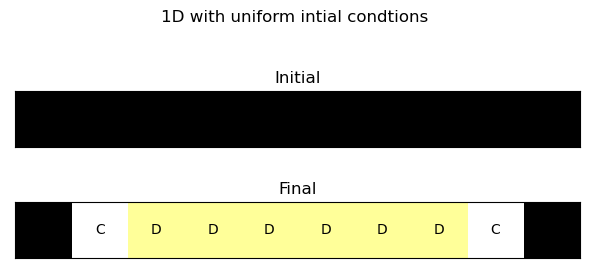

In [214]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


initial_grid = history[0]
final_grid = grid 

initial_groups = [get_group(state) for state in initial_grid]
final_groups = [get_group(state) for state in final_grid]

initial_colors = [group_colors.get(g, '#808080') for g in initial_groups]
final_colors   = [group_colors.get(g, '#808080') for g in final_groups]


initial_int = np.array([color_to_int[c] for c in initial_colors]).reshape(1, grid_size)
final_int = np.array([color_to_int[c] for c in final_colors]).reshape(1, grid_size)


cmap = mcolors.ListedColormap(unique_colors)
bounds = list(range(len(unique_colors) + 1))
norm = mcolors.BoundaryNorm(bounds, cmap.N)


fig, (ax_initial, ax_final) = plt.subplots(2, 1, figsize=(grid_size * 0.6, 3))


im0 = ax_initial.imshow(initial_int, cmap=cmap, norm=norm)
ax_initial.set_title("Initial")
ax_initial.set_xticks([])
ax_initial.set_yticks([])


for j in range(grid_size):
    ax_initial.text(j, 0, initial_groups[j] or '?', ha='center', va='center', fontsize=10, color='black')


im1 = ax_final.imshow(final_int, cmap=cmap, norm=norm)
ax_final.set_title("Final")
ax_final.set_xticks([])
ax_final.set_yticks([])


for j in range(grid_size):
    ax_final.text(j, 0, final_groups[j] or '?', ha='center', va='center', fontsize=10, color='black')

#plt.suptitle(f"Initial vs Final Grouping in 1D Grid (t = {timesteps})", y=1.0)
plt.suptitle("1D with uniform intial condtions", y=1.0)
plt.tight_layout()
plt.show()


In [ ]:
# --- 1D Grid Plot with Square Cells ---
group_labels = [get_group(state) for state in grid]
color_list = [group_colors.get(g, '#808080') for g in group_labels]

# Build a 2D array of shape (1, grid_size) for imshow
color_grid = np.array([color_list])

# Convert to integer grid
unique_colors = list(group_colors.values()) + ['#808080']
color_to_int = {c: i for i, c in enumerate(unique_colors)}
int_grid = np.vectorize(color_to_int.get)(color_grid)

# Plot
fig, ax = plt.subplots(figsize=(grid_size * 0.4, 1.5))  # Adjust size for spacing
cmap = mcolors.ListedColormap(unique_colors)
bounds = list(range(len(unique_colors) + 1))
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax.imshow(int_grid, cmap=cmap, norm=norm)

# Add group labels
for j in range(grid_size):
    group = group_labels[j]
    ax.text(j, 0, group or '?', ha='center', va='center', fontsize=10, color='black')

# Formatting
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"Final Grouping in 1D Grid at t = {timesteps}")
ax.set_aspect('equal')  # force square cells
plt.tight_layout()
plt.show()
